In [1]:
%env MONGO_PW changeme
import os
import pymongo
mongoUri = 'mongodb://{id}:{pw}@{endpoint}/{db}?authSource={db}'
client = pymongo.MongoClient(
    mongoUri.format(
        id="2020sw",
        pw=os.environ['MONGO_PW'],
        endpoint="iwanhae.iptime.org",
        db="2020sw"
    ))
db = client.get_database()

print("Available collections:")
for c in db.list_collection_names():
    print("\t", c, db.get_collection(c).estimated_document_count())

env: MONGO_PW=swswsw
Available collections:
	 articles 760535
	 ranked 2089


In [ ]:
# json 파일을 그대로 DB에 넣어버리는 코드
col = client.get_database().get_collection("articles")
col.create_index([('date', pymongo.ASCENDING)])

from datetime import datetime

for fname in os.listdir('data'):
    with open(os.path.join('data', fname)) as f:
        data = json.load(f)
        for o in data:
            o['date'] = datetime.strptime(o['date'], "%Y.%m.%d")
        col.insert_many(data)
    print(fname)

In [ ]:
# articles에 들어있는 기사에서 명사(keyword) 추출하는 코드

# %%
print("Init Collection")
col = db.get_collection("articles")
col.update_many({"status": { "$exists":False }}, {"$set": {"status": 0}}) # 새로 추가된 기사
col.update_many({"status": 1}, {"$set": {"status": 0}}) # 파싱 안된 기사
col.create_index([("status", pymongo.DESCENDING)])
# %%
print("Init Kkma")
from konlpy.tag import Kkma
km = Kkma()
# %%
col = db.get_collection("articles")
while True:
    doc = col.find_one_and_update({"status" : 0}, {"$set": {"status": 1}})
    if doc == None:
        break
    print(doc['link'], doc['title'])
    keywords = {}
    for noun in km.nouns(doc['body']):
        if len(noun) < 2:
            continue
        if noun not in keywords:
            keywords[noun] = 0
        keywords[noun] += 1
    col.find_one_and_update({"_id": doc["_id"]}, {"$set": {"status": 2, "keywords": keywords}})
    print(doc['link'], doc['title'], len(keywords))
print("Finished")

In [ ]:
# status: 2 에서 status: 3 포맷으로 바꾸는 코드
col = db.get_collection("articles")
while True:
    doc = col.find_one({"status": 2})
    if doc == None:
        break
    keywords = []
    for k in doc["keywords"].keys():
        keywords.append({
            "name": k,
            "value": doc["keywords"][k]
        })
    col.find_one_and_update({"_id": doc['_id']}, {"$set": { "keywords": keywords, "status": 3}})
    print(doc['link'], doc['title'], len(keywords))
print("Finished")

In [ ]:
# pagerank 작업할 DB placeholder 만드는 코드
from datetime import datetime, timedelta
from IPython.display import clear_output

articles = db.get_collection("articles")
ranked = db.get_collection("ranked")
ranked.create_index([("status", pymongo.DESCENDING)])
ranked.create_index([("date", pymongo.DESCENDING)], unique=True)
for date in articles.find({"status": 3}).distinct("date"):
    clear_output(wait=True)
    print(date)
    ranked.insert_one({
        "date": date,
        "status": 0,
        "keywords": []
    })

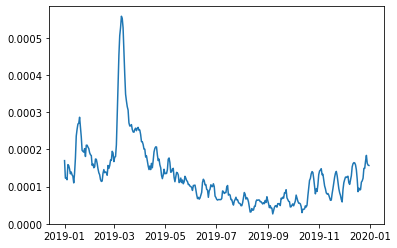

In [2]:
from datetime import datetime, timedelta
from IPython.display import clear_output
#시작날짜부터 종료날짜까지 키워드 데이터 가져오는 함수
def fetchKeywords(since : datetime, until : datetime) -> {}:
    col = db.get_collection("ranked")
    data = {}
    length = (until - since).days + 1
    for doc in col.find({
        'status': 2,
        'date': {
            '$gte': since,
            '$lte': until
        }
    }):
        date = doc['date']
        delta = (date - since).days
        for keyword in doc['keywords']:
            key = keyword['name']
            if key not in data:
                data[key] = [0 for i in range(length)]
            data[key][delta] = keyword['rank']
        print(date)
        clear_output(wait=True)
    return data
#이동평균과 유사하게 데이터 처리해주는 함수
def movingmean(d, size = 3):
    data = [0 for i in range(len(d))]
    for i in range(size):
        total = 0
        for j in range(i + 1):
            total += d[j]
        data[i] = total / (i + 1)
    for i in range(size, len(d)):
        total = 0
        for j in range(size):
            total += d[i-j]
        data[i] = total / size
    return data
#특정 키워드의 랭크 리스트값을 받아서 증감수치로만 변환해주는 함수
def calVariance(data):
    result=[0]
    for i in range(1,len(data)):
        if data[i]==data[i-1]:
            result.append(0)
        elif data[i]>data[i-1]:
            result.append(1)
        else:
            result.append(-1)
    return result
# 1, 0, -1 로 변환된 두 데이터의 유사도를 비교하는 함수 클수록 유사도가 높음
def compData(keyResult, userResult):
    compResult=0
    for i in range(len(userResult)):
        if keyResult[i]==userResult[i]:
            compResult+=1
    return compResult
since = datetime(2019,1,1)
until = datetime(2019,12,31)
tmp = fetchKeywords(since, until)

from matplotlib import pyplot as plt
key = "미세먼지"
mean = movingmean(tmp[key], 7) # 주단위로 분석
plt.plot([since + timedelta(i) for i in range(len(mean))], mean)
# 3월 ~ 4월에 미세먼지에 대한 관심이 큰것을 알 수 있다.

기간 2019-01-01 00:00:00 ~ 2019-12-31 00:00:00
Increment Distance :  0.43561643835616437


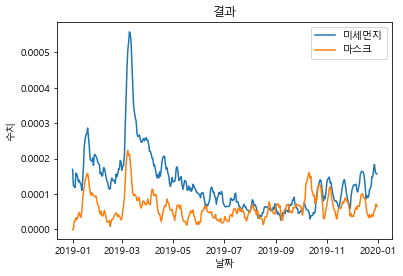

In [15]:
#비교할 키워드 입력
key1 = "미세먼지"
key2 = "마스크"
mean1 = movingmean(tmp[key1], 7) # 주단위로 분석
mean2 = movingmean(tmp[key2], 7) # 주단위로 분석

#Increment Distance
userResult = calVariance(mean1)
Ic_distance = 1 - (compData(calVariance(mean2),userResult) / compData(calVariance(mean1),userResult))

#결과 출력
print("기간", since ,"~", until )
print("Increment Distance : ",Ic_distance)
plt.rc('font', family='Malgun Gothic')
plt.plot([since + timedelta(i) for i in range(len(mean1))], mean1, label = key1)
plt.plot([since + timedelta(i) for i in range(len(mean2))], mean2, label = key2)
plt.title("결과")
plt.xlabel("날짜")
plt.ylabel("수치")
plt.legend()